In [3]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=16bea57fa492539084f05bd32b809a26e9c4a5389ff7a9c6b80135a6221e1bd1
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [22]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random , os , glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

#warningleri kapatmak için
import warnings
warnings.filterwarnings('ignore')

#Model değerleendirmek için kullanılacak kütüphane
from sklearn.metrics import confusion_matrix , classification_report

#Model İçin Kullanılacak Kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D , Flatten , MaxPooling2D , Dense , Dropout , SpatialDropout2D , GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array , load_img , array_to_img
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from keras.utils import to_categorical

In [8]:
dir_path = '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset'
#Target Size ve Label Etiketlerin Belirlenmesi
target_size = (224,224)

In [11]:
def load_datasets(path):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(path)))
    for image_path in image_paths:
        #Belirtilen Görüntüleri Open CV İle Oku
        img = cv2.imread(image_path)

        #Okunan görüntüleri başlangıçta belirlenen target_sizea göre yeniden ölçeklendir
        img = cv2.resize(img , target_size)

        #ölçeklendirilen görüntüyü x listesine ekle
        x.append(img)

        #Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labelı temsil etmektedir
        label = image_path.split(os.path.sep)[-2]

        #yakalanan labelların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içersinden gönderilen key
        #değerine karşılık value değeri alınarak label oluşturulur
        labels.append(label)

    #veri seti random bir sekilde karıştırılır
    x , labels = shuffle(x,labels,random_state=42)

    #boyut ve sınıf bilgisi raporlanmaktadır
    print(f"X boyutu:{np.array(x).shape}")
    print(f"label sınıf sayısı:{len(np.unique(labels))} Gözlem Sayısı:{len(labels)}")

    return x, labels

In [12]:
x,labels = load_datasets(dir_path)

X boyutu:(500, 224, 224, 3)
label sınıf sayısı:5 Gözlem Sayısı:500


In [14]:
input_shape = (np.array(x[0]).shape[1],np.array(x[0]).shape[1],3)
print(input_shape)

(224, 224, 3)


In [15]:
def visualize_img(image_batch , label_batch):
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(label_batch[n])
        plt.axis("off")

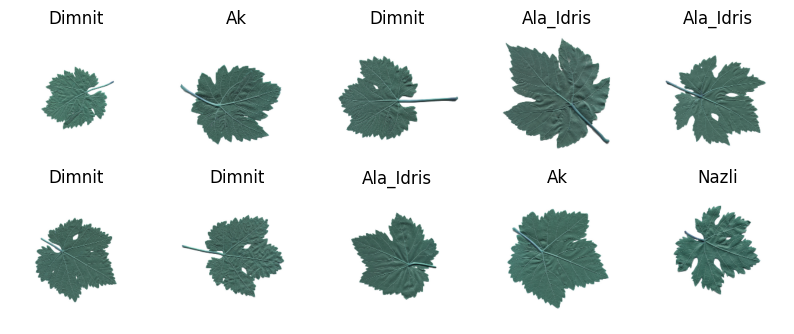

In [16]:
visualize_img(x,labels)

In [17]:
#Train veri seti için bir generator tanımlıyoruz. ==> Kırpma , döndürme bölme , gürültü ekleme , modelin aşırı uyum önler

train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1, #Eğim Vermek
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)
#Test verisi için generator Tanımlama
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

In [18]:
train_generator = train.flow_from_directory(directory=dir_path,
    target_size=(target_size),
    class_mode='categorical',
    subset='training'
)

test_generator = test.flow_from_directory(
    directory=dir_path,
    target_size=(target_size),
    batch_size=251,
    class_mode='categorical',
    subset='validation'
)

Found 450 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [23]:
# Model Architecture
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(5, activation='softmax')(x)  # Adjust NUM_CLASSES to your task

model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)

Epoch 1/20
15/15 [==============================] - 9s 564ms/step - loss: 0.9080 - accuracy: 0.6733 - val_loss: 0.8924 - val_accuracy: 0.7600
Epoch 2/20
15/15 [==============================] - 8s 543ms/step - loss: 0.8442 - accuracy: 0.7178 - val_loss: 0.8749 - val_accuracy: 0.7000
Epoch 3/20
15/15 [==============================] - 8s 534ms/step - loss: 0.7678 - accuracy: 0.7511 - val_loss: 0.7458 - val_accuracy: 0.7800
Epoch 4/20
15/15 [==============================] - 8s 532ms/step - loss: 0.7499 - accuracy: 0.7689 - val_loss: 0.7430 - val_accuracy: 0.7600
Epoch 5/20
15/15 [==============================] - 8s 533ms/step - loss: 0.6814 - accuracy: 0.7911 - val_loss: 0.7223 - val_accuracy: 0.8000
Epoch 6/20
15/15 [==============================] - 8s 521ms/step - loss: 0.6722 - accuracy: 0.7778 - val_loss: 0.7376 - val_accuracy: 0.7400
Epoch 7/20
15/15 [==============================] - 8s 532ms/step - loss: 0.6536 - accuracy: 0.7867 - val_loss: 0.7426 - val_accuracy: 0.8200
Epoch 

Text(0.5, 1.0, 'Training and Validation Loss')

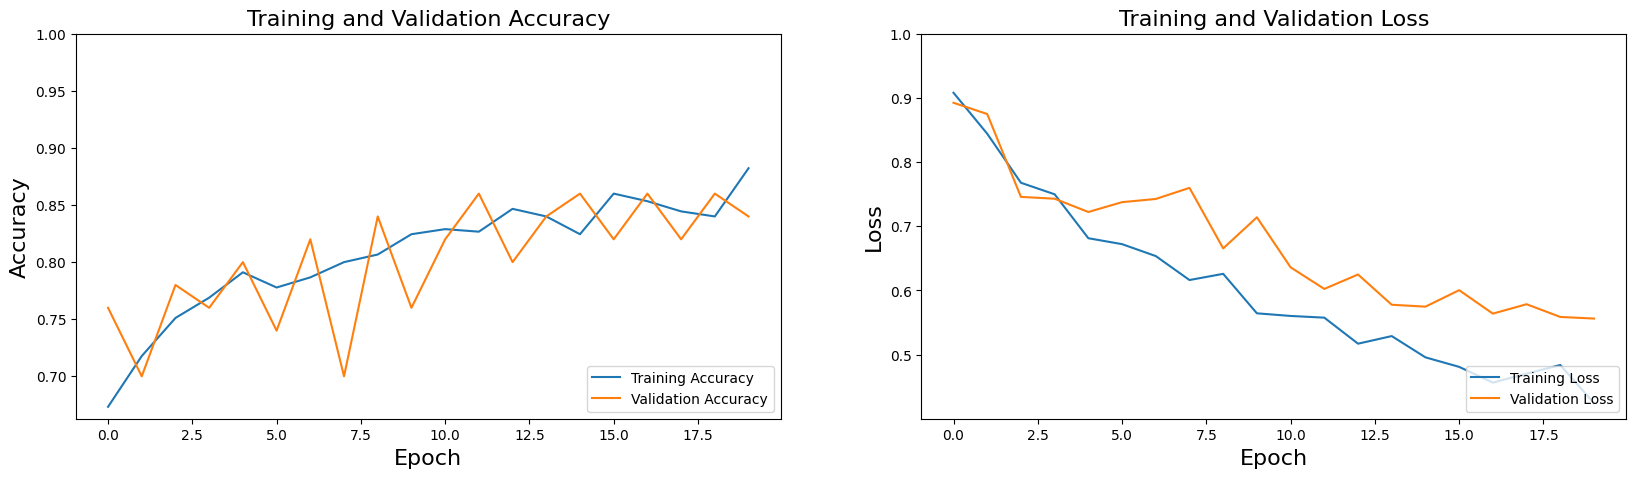

In [30]:
#------------------------
#Accuracy Grafik
#------------------------

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontsize=16)


#------------------------
#Loss Grafik
#------------------------

plt.subplot(1,2,2)
plt.plot(model.history.history['loss'],label='Training Loss')
plt.plot(model.history.history['val_loss'],label='Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss',fontsize=16)